In [7]:
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [9]:
# define training and test data directories
data_dir = '/content/drive/MyDrive/Colab Notebooks/flower_photos/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

# classes are folders in each directory with these names
classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [10]:
# load and transform data using ImageFolder

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transform = transforms.Compose([transforms.RandomResizedCrop(224), 
                                      transforms.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))

Num training images:  3130
Num test images:  540


In [11]:
# define dataloader parameters
batch_size = 20
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

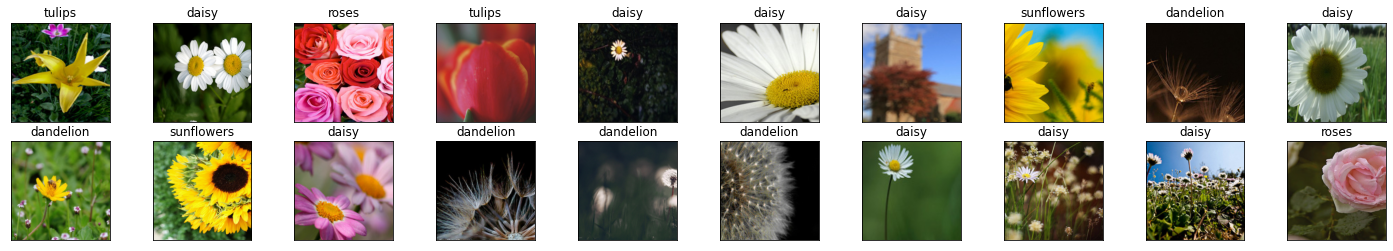

In [12]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [13]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

# print out the model structure
print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [14]:
print(vgg16.classifier[6].in_features) 
print(vgg16.classifier[6].out_features) 

4096
1000


In [15]:
# Freeze training for all "features" layers
for param in vgg16.features.parameters():
    param.requires_grad = False

In [16]:
import torch.nn as nn## TODO: add a last linear layer  that maps n_inputs -> 5 flower classes
## new layers automatically have requires_grad = True

vgg16.classifier[6] = nn.Linear(4096,5)


# after completing your model, if GPU is available, move the model to GPU
if train_on_gpu:
    vgg16.cuda()

vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [17]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

In [20]:
# # number of epochs to train the model
# n_epochs = 2

# for epoch in range(1, n_epochs+1):

#     # keep track of training and validation loss
#     train_loss = 0.0
    
#     ###################
#     # train the model #
#     ###################
#     # model by default is set to train
#     for batch_i, (data, target) in enumerate(train_loader):
#         # move tensors to GPU if CUDA is available
#         if train_on_gpu:
#             data, target = data.cuda(), target.cuda()
#         # clear the gradients of all optimized variables
#         optimizer.zero_grad()
#         # forward pass: compute predicted outputs by passing inputs to the model
#         output = vgg16(data)
#         # calculate the batch loss
#         loss = criterion(output, target)
#         # backward pass: compute gradient of the loss with respect to model parameters
#         loss.backward()
#         # perform a single optimization step (parameter update)
#         optimizer.step()
#         # update training loss 
#         train_loss += loss.item()
        
#         if batch_i % 20 == 19:    # print training loss every specified number of mini-batches
#             print('Epoch %d, Batch %d loss: %.16f' %
#                   (epoch, batch_i + 1, train_loss / 20))
#             train_loss = 0.0

In [21]:
# number of epochs to train the model
# n_epochs = 2

## TODO complete epoch and training batch loops
## These loops should update the classifier-weights of this model
## And track (and print out) the training loss over time

epochs = 2
steps = 0
running_loss = 0
print_every = 5

for epoch in range(epochs):
    for images, labels in train_loader:
        steps += 1
        
            # Move input and label tensors to the default device
        images, labels = images.cuda(), labels.cuda()
        
        optimizer.zero_grad()
        
        logps = vgg16(images)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        if steps % 20 == 19:
            print(f"Epoch {epoch+1}/{epochs}.. "
              f"Train loss: {running_loss/20:.3f}")
        running_loss = 0



Epoch 1/2.. Train loss: 0.049
Epoch 1/2.. Train loss: 0.051
Epoch 1/2.. Train loss: 0.043
Epoch 1/2.. Train loss: 0.046
Epoch 1/2.. Train loss: 0.044
Epoch 1/2.. Train loss: 0.047
Epoch 1/2.. Train loss: 0.028
Epoch 2/2.. Train loss: 0.036
Epoch 2/2.. Train loss: 0.044
Epoch 2/2.. Train loss: 0.025
Epoch 2/2.. Train loss: 0.043
Epoch 2/2.. Train loss: 0.040
Epoch 2/2.. Train loss: 0.031
Epoch 2/2.. Train loss: 0.044
Epoch 2/2.. Train loss: 0.025


In [22]:
# track test loss 
# over 5 flower classes
test_loss = 0.0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))

vgg16.eval() # eval mode

# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = vgg16(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.658310

Test Accuracy of daisy: 76% (70/92)
Test Accuracy of dandelion: 87% (116/132)
Test Accuracy of roses: 70% (64/91)
Test Accuracy of sunflowers: 71% (72/101)
Test Accuracy of tulips: 71% (89/124)

Test Accuracy (Overall): 76% (411/540)


In [37]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = vgg16(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
# preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().detach().numpy())
preds = preds_tensor.cpu().detach().numpy()

preds
# # plot the images in the batch, along with predicted and true labels
# fig = plt.figure(figsize=(25, 4))
# for idx in np.arange(20):
#     ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
#     plt.imshow(np.transpose(images[idx], (1, 2, 0)))
#     ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
#                  color=("green" if preds[idx]==labels[idx].item() else "red"))

array([2, 3, 4, 4, 4, 4, 2, 3, 2, 3, 4, 0, 0, 1, 3, 4, 4, 4, 0, 4])

In [41]:
yes = 0
no = 0
for i in range(len(preds)):
    print(classes[preds[i]], classes[labels[i]])
    if (classes[preds[i]] == classes[labels[i]]):
        yes+=1
    else:
        no+=1

print(yes,no)

roses roses
sunflowers tulips
tulips tulips
tulips tulips
tulips tulips
tulips tulips
roses roses
sunflowers sunflowers
roses tulips
sunflowers roses
tulips roses
daisy daisy
daisy daisy
dandelion dandelion
sunflowers sunflowers
tulips tulips
tulips tulips
tulips tulips
daisy daisy
tulips tulips
16 4
